## Understanding Eigenfishes copied code from https://github.dev/profConradi/eigenfish/blob/main/Eigenfish_notebook.ipynb


In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams["text.latex.preamble"] = r"\usepackage{amsmath}\usepackage{amsfonts}"
%config InlineBackend.figure_format = 'retina'

class Eigenfish:
    """
    A class for building an eigenfish plot.
    Parameters:
        matrix: a two-dimensional square ndarray
        indices_of_ts: a set of elements of matrix which are replace by parameters t_1, t_2, ..., t_n
                       for example (array([0, 5]), array([6, 3])) means that elements (0,6) and (5,3) are replaced
                       by t_1 and t_2
        
    """
    def __init__(self, matrix, indices_of_ts):
        self.matrix = matrix
        self.indices_of_ts = indices_of_ts #indices of parameters
        self.mdim = matrix.shape[0] #dimension of the matrix
        self.n_t = len(self.indices_of_ts[0])
        self.is_matrix_of_phases = np.all(np.abs(self.matrix)==1.0)
        
    def eigvals_random_ts_rect(self, n_ts, r):
        """
        This method calculate eigenvalues of the matrix, sampling t_1, t_2, ..., t_n parameters
        from an uniform probability distribution with support [-r, r] x [-r, r] x ... x [-r, r] 
        Parameters:
            n_ts: the number of sampled tuple (t_1, t_2, ..., t_n)
            r: defining the support range of the uniform probability distribution
        Returns:
            the ndarray of eigenvalues. Its number of elements is equal to n_ts * self.mdim
        """
        eigenvalues = np.zeros(n_ts*self.mdim, dtype=np.complex64)
        for i in range(n_ts):
            ts = tuple([np.random.uniform(-r,r) for _ in range(self.n_t)])
            self.matrix[self.indices_of_ts]=ts
            eigenvalues[i*self.mdim:(i+1)*self.mdim] = np.linalg.eigvals(self.matrix)
        return eigenvalues 
    
    def eigvals_normal_ts_rect(self, n_ts, s):
        """
        This method calculate eigenvalues of the matrix, sampling t_1, t_2, ..., t_n parameters
        from a multivariate normal probability distribution with standard deviation equal to s
        Parameters:
            n_ts: the number of sampled tuple (t_1, t_2, ..., t_n)
            s: standard deviation of th normal probability distribution
        Returns:
            the ndarray of eigenvalues. Its number of elements is equal to n_ts * self.mdim
        """
        eigenvalues = np.zeros(n_ts*self.mdim, dtype=np.complex64)
        for i in range(n_ts):
            ts = tuple([np.random.normal(0,s) for _ in range(self.n_t)])
            self.matrix[self.indices_of_ts]=ts
            eigenvalues[i*self.mdim:(i+1)*self.mdim] = np.linalg.eigvals(self.matrix)
        return eigenvalues 
    
    def eigvals_random_ts_torus(self, n_ts, radius=1.0):
        """
        This method calculate eigenvalues of the matrix, sampling t_1, t_2, ..., t_n parameters
        from an uniform probability distribution on a torus
        Parameters:
            n_ts: the number of sampled tuple (t_1, t_2, ..., t_n)
            radius: the value of tours radius, it is the same for each dimension
        Returns:
            the ndarray of eigenvalues. Its number of elements is equal to n_ts * self.mdim
        """
        eigenvalues = np.zeros(n_ts*self.mdim, dtype=np.complex64)
        for i in range(n_ts):
            ts = tuple([radius*np.exp(1.j*np.random.uniform(0., 2*np.pi)) for _ in range(self.n_t)])
            self.matrix[self.indices_of_ts]=ts
            eigenvalues[i*self.mdim:(i+1)*self.mdim] = np.linalg.eigvals(self.matrix)
        return eigenvalues
    
    def gershgorin_circles(self):
        """
        This methods calculate Gershgorin circle in the case of a matrix in which the absolute value of
        each element is equal to one.
        This method has to be improved. TODO.
        Please see https://en.wikipedia.org/wiki/Gershgorin_circle_theorem.
        Returns:
            a tuple containing 3 ndarray: x coordinate of circles centers, y coordinate of circles centers,
                                          radius of circles.
        """
        if self.is_matrix_of_phases:
            diag_elms = np.diag(self.matrix)
            radiuses = (mdim-1)*np.ones(mdim)
            return np.real(diag_elms), np.imag(diag_elms), radiuses
        else:
            return None

    def latex_matrix(self, max_real="1"):
        
        def clean(val):
            real, imag = np.real(val), np.imag(val)
            if imag != 0:
                return "i" if imag > 0 else "-i"
            real = str(real).replace(".0", "")
            return real if real in ["0", "0.5", max_real] else "tT"
        
        template = r" \\ ".join([" & ".join(["{}"] * self.mdim)] * self.mdim)
        filled = template.format(*map(clean, self.matrix.flatten()))
        final = filled.replace("T", "{}").format(*range(1, self.n_t+1))
        return r"\begin{pmatrix} " + final + r" \end{pmatrix}"

    def create_simple_latex_title_rect(self, rmin, rmax):
        title = self.latex_matrix()
        return f"$ {title} $"

    def create_latex_title_rect(self, rmin, rmax):
        title = (r"\lambda \in \mathbb{C} | \det(A-\lambda I)=0, \quad A="
            + self.latex_matrix() 
            + r", \quad "
            + ",".join([f"t{n+1}" for n in range(self.n_t)])
            + f" \in ({rmin}, {rmax}) ")
        return f"$ {title} $"
            
    def create_latex_title_torus(self):
        title = (r"\lambda \in \mathbb{C} | \det(A-\lambda I)=0, \quad A="
            + self.latex_matrix(max_real="0.2") 
            + r", \quad "
            + ",".join([f"t{n+1}" for n in range(self.n_t)])
            + r" \in S^{1} \times S^{1}")
        return f"$ {title} $"


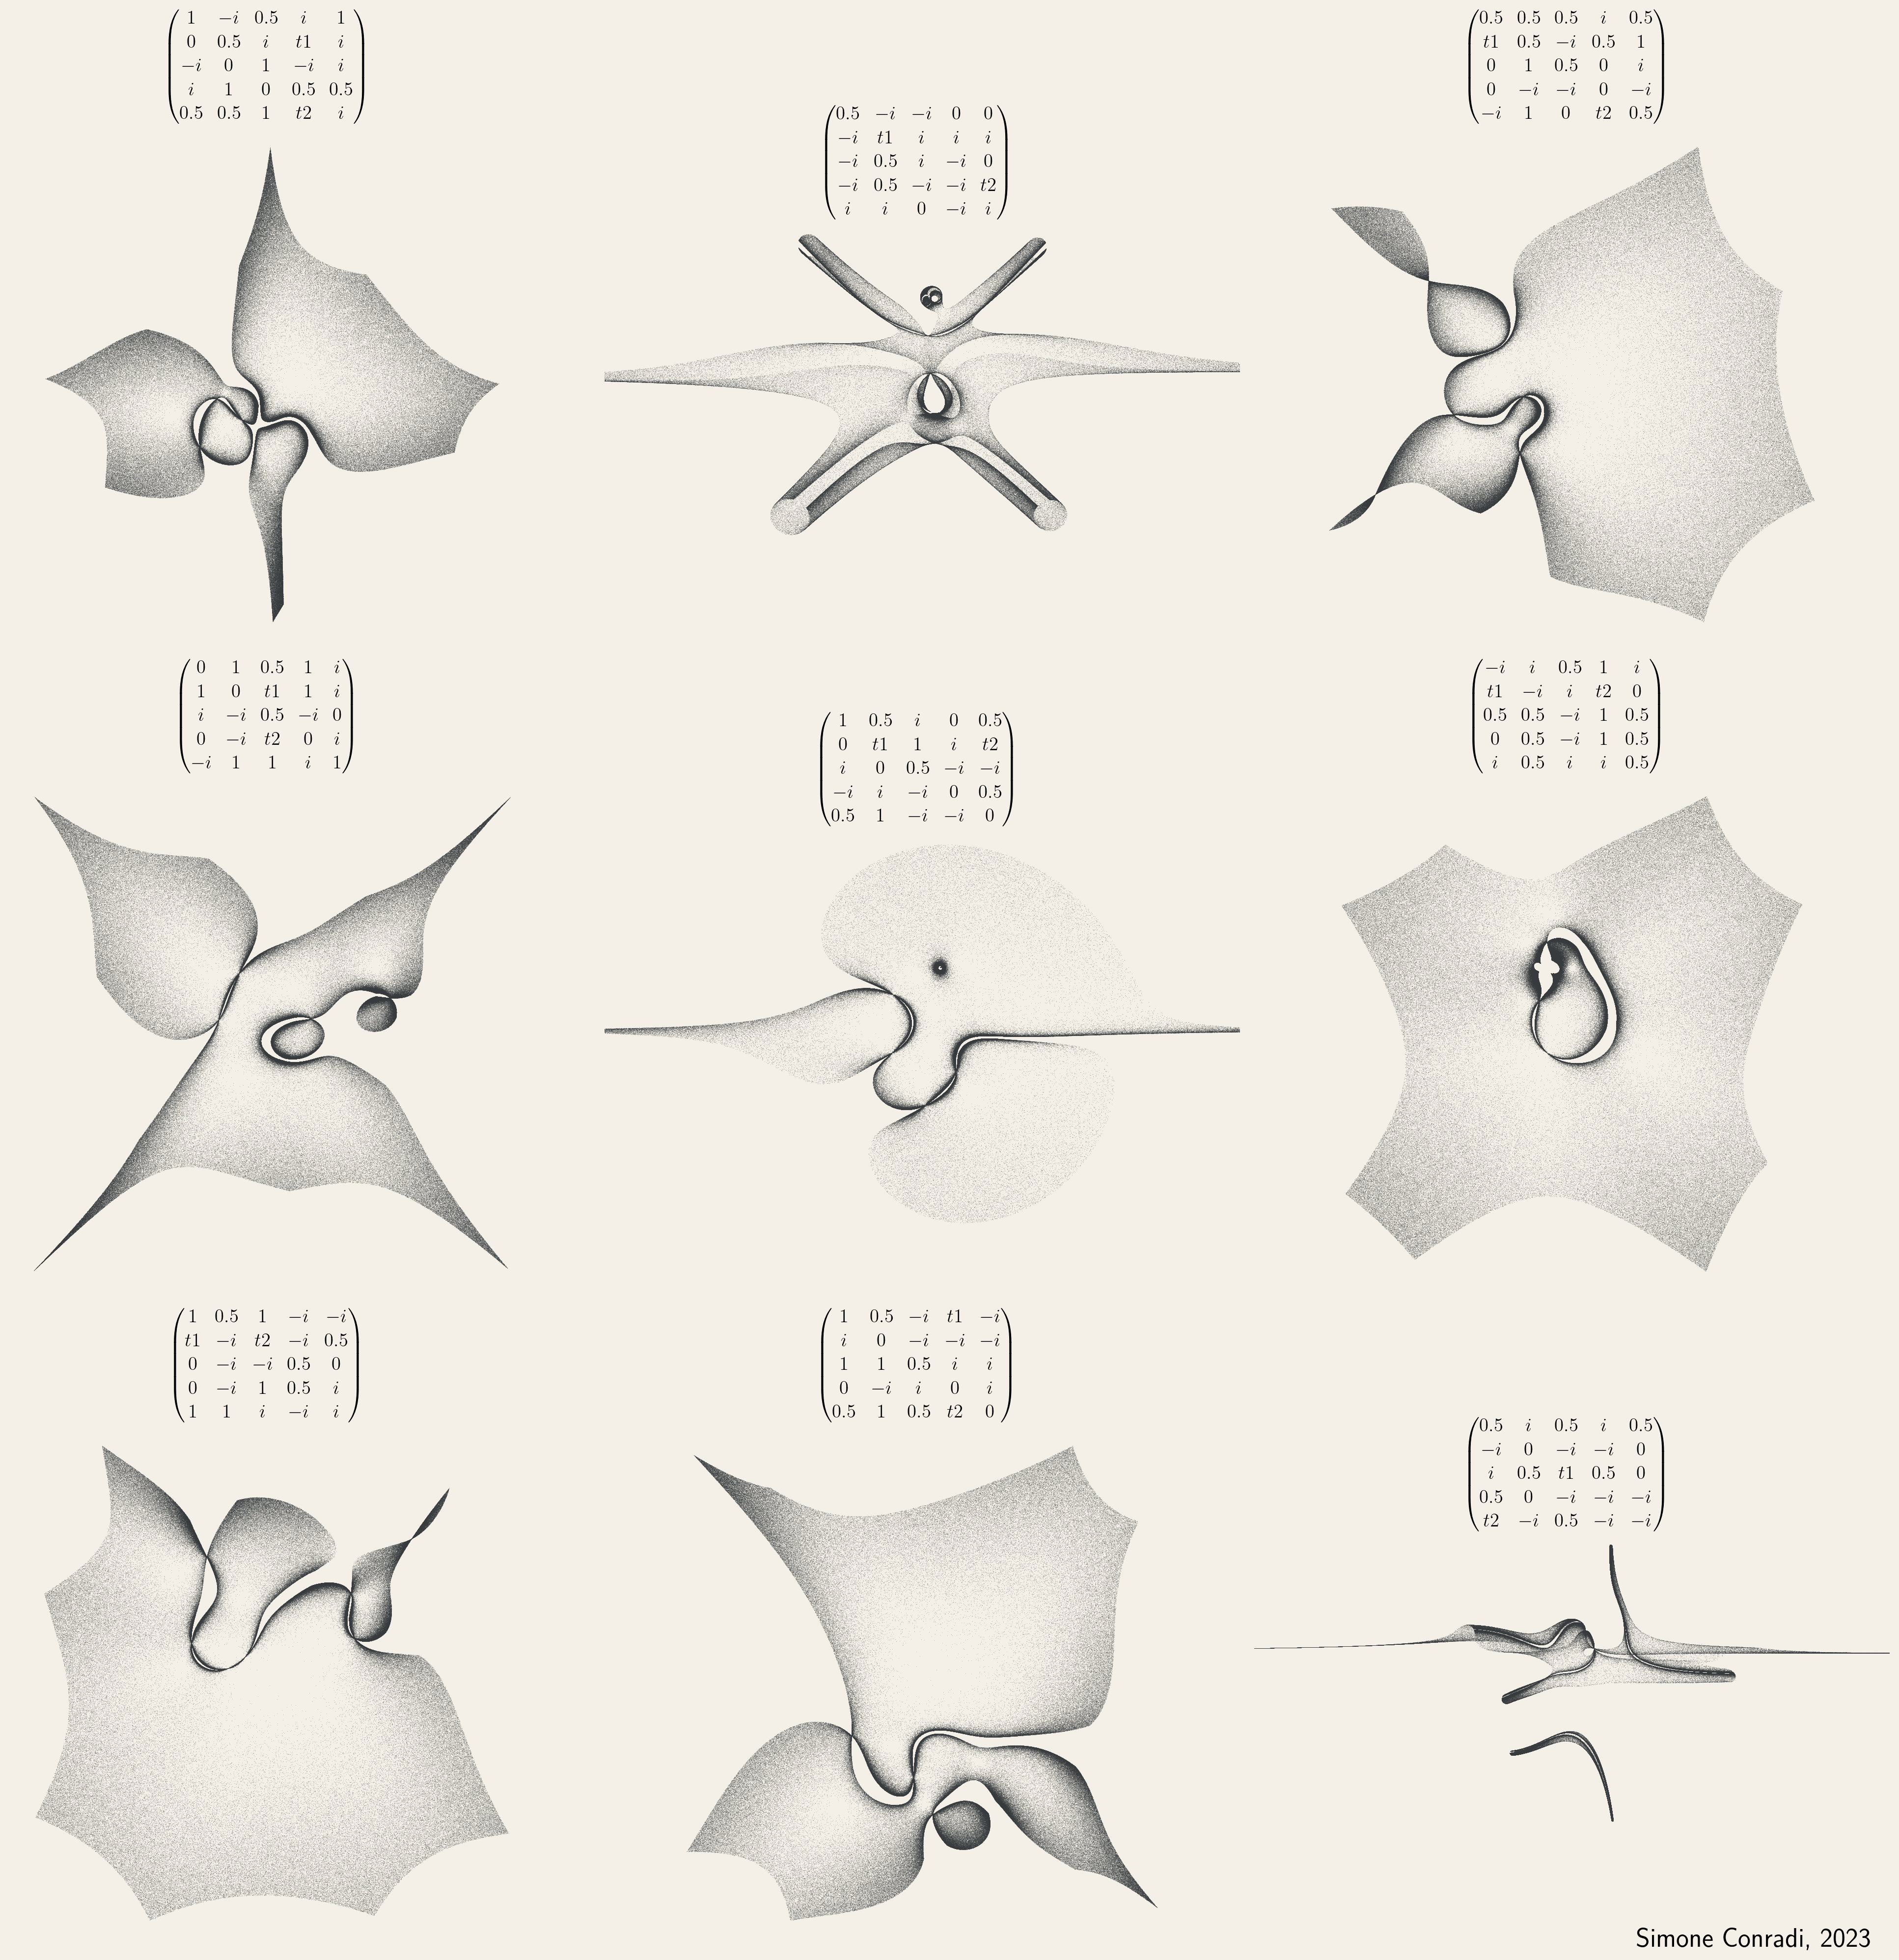

In [14]:
mdim = 5
population = np.array([0.,-1.j,1.j,1.,0.5]) # array([ 0+0i, -0-1i,  0+1i,  1+0i,  0.5+0i])
r = 20
n_matrix = 100000
list_of_figure = []


fig, axs = plt.subplots(3, 3, figsize=(20,20)) # fig contains all subplots, axs contains array of axes objects 
fig.set_facecolor("#f4f0e8") # sets tan background 
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #rotates perspective each plot is facing 


for ax in axs.reshape(-1):
     # for each axes object, make all sides invisible to start 
    for spine in ['top', 'right','left','bottom']:
        ax.spines[spine].set_visible(False)

    # Generate a 5x5 random matrix that is in can pick from (0, -i, +i, 1, 0.5)
    matrix = np.random.choice(population, (mdim,mdim))+0.j
     # pick 2 sets of 2 indicies from range 0->24 from this random matrix and store as (array[i1, i2], array[i3, i4])
    var_indices = np.unravel_index(np.random.choice(np.arange(0, mdim**2), 2, replace=False), (mdim,mdim))

    # Create eigenfish object, append the object to list
    eigenfish = Eigenfish(matrix, var_indices)
    list_of_figure.append(eigenfish)
    
    # Sample n=100,000 sampled tuples with r=20 support range of uniform distribution, and return its eigenvalues 
    eigenvalues = eigenfish.eigvals_random_ts_rect(n_matrix, r)

    # create a scatter plot with real components coeff on x-axis and imaginary components coeff on y-axis 
    ax.scatter(np.real(eigenvalues), np.imag(eigenvalues), c="#383b3e", s=0.03, linewidths= 0.0001, alpha=1.)
    ax.set_title(eigenfish.create_simple_latex_title_rect(-r,r), fontsize=14)
    ax.set_aspect('equal', 'box') # ensures equal aspect ratio of x and y on each graph 
    
    if np.max(np.real(eigenvalues)>10):
        ax.set_xlim([-8,8])
    #ax.set_ylim([-7,7])
    ax.set_axis_off()
plt.tight_layout()
plt.annotate("Simone Conradi, 2023", (1200.,10.), xycoords="figure points", fontsize=20)
plt.show()    

## My Own Code 